# Polarization reconstruction with neutrinos

### Dec 1, 2020

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
import deDisperse_util as util
from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")

Welcome to JupyROOT 6.18/04


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


## Events debugging

In [97]:
appended_data = []
import os
for filename in os.listdir("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/Bessel/"):#Loop over desired directory
        if (filename.startswith("pol_quant_noiseless_")): #extension, .root in this case
            name = os.path.join("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/Bessel/", str(filename))
            data = pd.read_pickle(name)
            appended_data.append(data)
recoNu = pd.concat(appended_data)     

recoNu = recoNu.loc[recoNu.rmsV>50]
recoNu = recoNu.loc[recoNu.rmsV<1400]
recoNu = recoNu.loc[recoNu.rmsH>50]
recoNu = recoNu.loc[recoNu.rmsH<1400]
# recoNu = recoNu.loc[recoNu.theta_reco<np.pi/2+0.2]


array2 = []
R_True = []
R_Reco = []
propVec = []
dot = []
for i in recoNu.itertuples(): 
    thetaHat = np.array([np.cos(i.theta_reco)*np.cos(i.phi_reco), np.cos(i.theta_reco)*np.sin(i.phi_reco), -np.sin(i.theta_reco)])
    phiHat = np.array([-np.sin(i.phi_reco), np.cos(i.phi_reco),0])
    R_Reco.append(np.sqrt(i.powerH/i.powerV))
    R = np.dot(i.PolTrue,phiHat)/(np.dot(i.PolTrue,thetaHat))
    R_True.append(R)
    array2.append(util.PolVectorRecoPower_debug(i.powerV,i.powerH, i.theta_reco, i.phi_reco,np.sign(R)))
    propVec = np.array([np.sin(i.theta_reco)*np.cos(i.phi_reco),np.sin(i.theta_reco)*np.sin(i.phi_reco),np.cos(i.theta_reco)])
    dot.append(np.dot(propVec,i.PolTrue))
recoNu["PolReco2"] = array2
# recoNu["PolReco2"] = util.PolVectorReco(recoNu.maxV, recoNu.maxH, recoNu.theta_reco,recoNu.phi_reco)

recoNu["R_True"] = R_True
recoNu["R_Reco"] = R_Reco
recoNu["dotProd"] = dot

# recoNu = recoNu.loc[abs(recoNu.dotProd)<0.0005]
recoNu = recoNu.loc[abs(recoNu.dotProd)>0.5]


Px_true = np.array([element[0] for element in recoNu.PolTrue])
Py_true = np.array([element[1] for element in recoNu.PolTrue])
Pz_true = np.array([element[2] for element in recoNu.PolTrue])

Px_reco = np.array([element[0] for element in recoNu.PolReco2])
Py_reco = np.array([element[1] for element in recoNu.PolReco2])
Pz_reco = np.array([element[2] for element in recoNu.PolReco2])


thetaPol_true = np.degrees(np.arccos(abs(Pz_true)))
thetaPol_reco = np.degrees(np.arccos(abs(Pz_reco)))
phiPol_true = np.degrees(np.arctan2(abs(Py_true),abs(Px_true)))
phiPol_reco = np.degrees(np.arctan2(abs(Py_reco),abs(Px_reco)))

recoNu["delta"] = thetaPol_reco-thetaPol_true
recoNu["deltaPhi"] = phiPol_reco-phiPol_true



delta = thetaPol_reco-thetaPol_true
deltaPhi = phiPol_reco-phiPol_true

# delta = delta[~np.isnan(delta)]

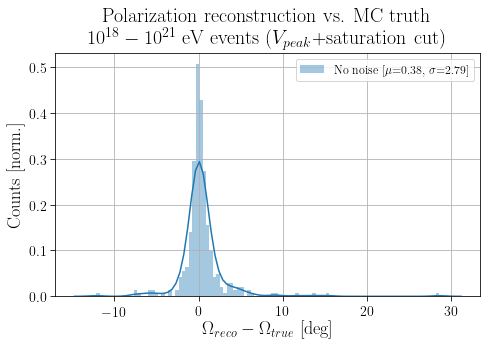

In [94]:
plt.figure(figsize=(7,5))
# plt.hist(recoNu.AngStokes-np.degrees(np.arccos(abs(recoNu.pol_z))), bins=100, density=False, alpha=1);
delta_std = (delta).std()
delta_mean = (delta).mean()
sns.distplot((delta), bins=100,label = "No noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

# delta_std = recoNu_noise.deltaTheta.std()
# delta_mean = recoNu_noise.deltaTheta.mean()
# plt.hist(recoNu_noise.deltaTheta, bins=500, density=True, alpha=0.5, color="C1",label = "W/noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

plt.xlabel("$\Omega_{reco}-\Omega_{true}$ [deg]")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm.]')
# plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events (no cuts)")
plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events ($V_{peak}$+saturation cut)")

# plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_Cuts_noAbs.png', dpi=150)


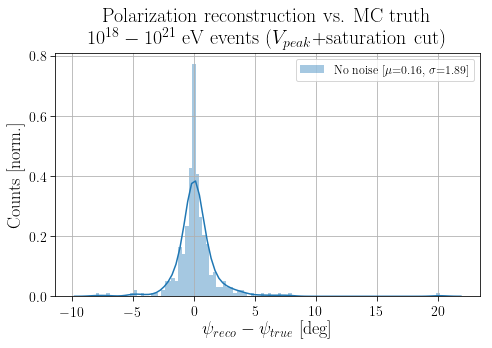

In [95]:
plt.figure(figsize=(7,5))
# plt.hist(recoNu.AngStokes-np.degrees(np.arccos(abs(recoNu.pol_z))), bins=100, density=False, alpha=1);
delta_std = (deltaPhi).std()
delta_mean = (deltaPhi).mean()
sns.distplot((deltaPhi), bins=100,label = "No noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

# delta_std = recoNu_noise.deltaTheta.std()
# delta_mean = recoNu_noise.deltaTheta.mean()
# plt.hist(recoNu_noise.deltaTheta, bins=500, density=True, alpha=0.5, color="C1",label = "W/noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

plt.xlabel("$\psi_{reco}-\psi_{true}$ [deg]")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm.]')
# plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events (no cuts)")
plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events ($V_{peak}$+saturation cut)")

# plt.yscale("log")
# mplcyberpunk.add_glow_effects()
# plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_Cuts.png', dpi=150)


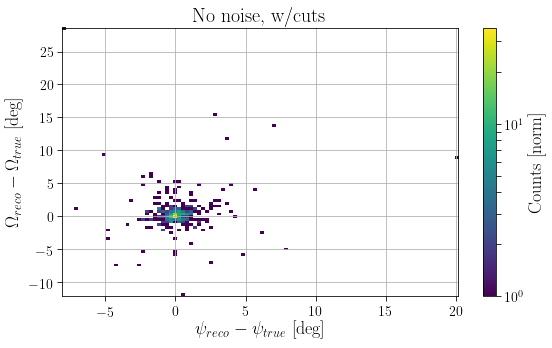

In [96]:
plt.figure(figsize=(8,5))
plt.hist2d(deltaPhi,delta, bins=100, normed=False,norm=mpl.colors.LogNorm());
# plt.hist2d(90-recoNu_noise.AngStokes,recoNu_noise.AngStokes-recoNu_noise.theta_pol, bins=100, normed=True,norm=mpl.colors.LogNorm());
# plt.title("No noise, no cuts")
plt.title("No noise, w/cuts")
# plt.hist2d(angle_Stokes,angle_Stokes-angle_true)
plt.grid()
plt.colorbar(label="Counts [norm]")
plt.ylabel("$\Omega_{reco}-\Omega_{true}$ [deg]")
plt.xlabel("$\psi_{reco}-\psi_{true}$ [deg]")
# plt.title("$10^{21}$ eV neutrinos")
plt.tight_layout()
# plt.xlim(0,90)
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_Cuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsReco_AraSim_noiseless_noCuts.png', dpi=150)

In [82]:
max(delta)

40.77423821650217

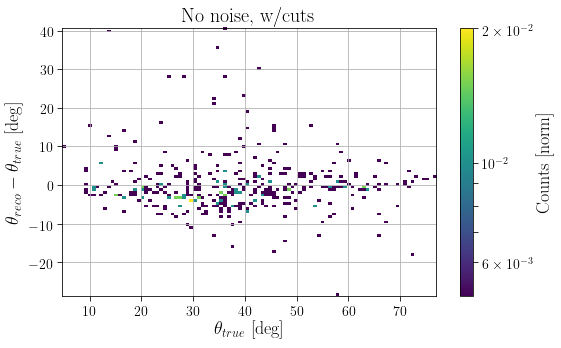

In [83]:
plt.figure(figsize=(8,5))
plt.hist2d(thetaPol_true,delta, bins=100, normed=True,norm=mpl.colors.LogNorm());
# plt.hist2d(90-recoNu_noise.AngStokes,recoNu_noise.AngStokes-recoNu_noise.theta_pol, bins=100, normed=True,norm=mpl.colors.LogNorm());
# plt.title("No noise, no cuts")
plt.title("No noise, w/cuts")
# plt.hist2d(angle_Stokes,angle_Stokes-angle_true)
plt.grid()
plt.colorbar(label="Counts [norm]")
plt.xlabel("$\\theta_{true}$ [deg]")
plt.ylabel("$\\theta_{reco}-\\theta_{true}$ [deg]")
# plt.title("$10^{21}$ eV neutrinos")
plt.tight_layout()
# plt.xlim(0,90)
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_Cuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsReco_AraSim_noiseless_noCuts.png', dpi=150)

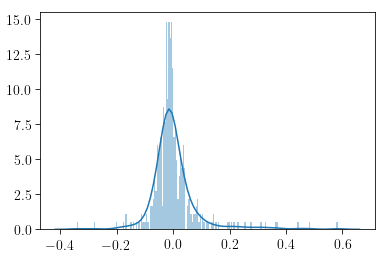

In [84]:
sns.distplot(abs(Pz_true)-abs(Pz_reco), bins = 200);

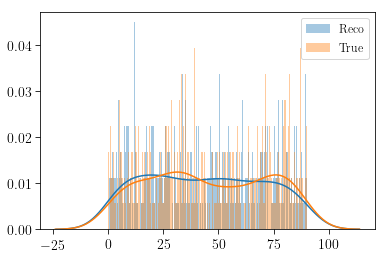

In [85]:
# Pz_true = Pz_true[Pz_true<0]
sns.distplot(phiPol_reco, bins=200, label = "Reco");
sns.distplot(phiPol_true, bins=200, label = "True");
plt.legend()

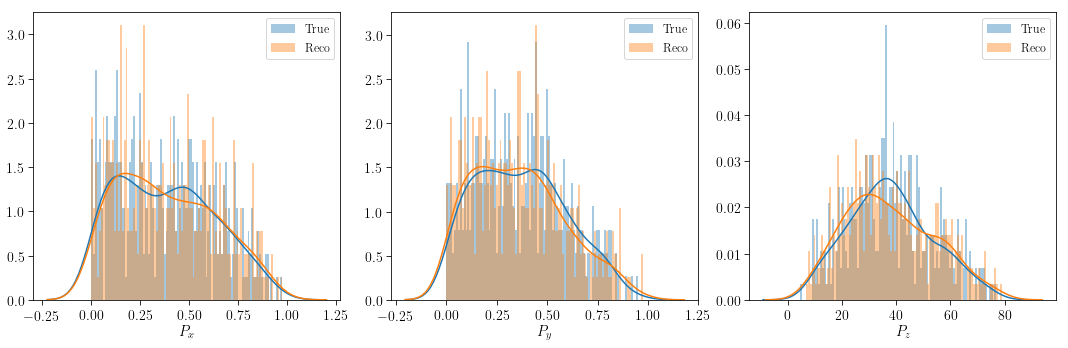

In [86]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))
f, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.distplot(abs(Px_true), bins=100, label= "True", ax=axes[0]);
sns.distplot(abs(Px_reco), bins=100, label= "Reco", ax=axes[0]);
axes[0].set_xlabel("$P_x$", fontsize=15)
# sns.legend()
axes[0].legend()

sns.distplot(abs(Py_true), bins=100, label= "True", ax=axes[1]);
sns.distplot(abs(Py_reco), bins=100, label= "Reco", ax=axes[1]);
axes[1].set_xlabel("$P_y$", fontsize=15)
# sns.legend()
axes[1].legend()

sns.distplot(np.degrees(np.arccos(abs(Pz_true))), bins=100, label= "True", ax=axes[2]);
sns.distplot(np.degrees(np.arccos((Pz_reco))), bins=100,label= "Reco", ax=axes[2]);
axes[2].set_xlabel("$P_z$", fontsize=15)
axes[2].legend()

plt.tight_layout()
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_PxPyPz.png', dpi=150)


### Make function to write input files

In [105]:
def makeInputFile(posnu_x, posnu_y, posnu_z, nnu_x, nnu_y, nnu_z, nuflavorint, nu_nubar, pnu, currentint, elast_y):
    """
    Make input file to be read by AraSim (only works if using A2). It's very rudimentary, but it works.
    Author: Jorge Torres, Dec 3.
    Parameters
    ----------
    All the inputs are given in AraSim output coordinates/units.
    Returns
    -------
    Prints something that can be copied and pasted as an input file.
    """
    #posnu
    posNu = np.array([posnu_x, posnu_y, posnu_z])
    avgVec = np.array([10000.83568, 9998.89765, 6359452.44702])
    posNu2 = posNu-avgVec #AraSim adds avgVec when transforming coordinates, and this is what AraSim outputs
    norm = np.linalg.norm(posNu2)
    posNu2 = posNu2/norm#Normalize
    posnu_r = norm
    
    posnu_theta = np.pi/2-np.arccos(posNu2[2])
    posnu_phi = np.arctan2(posNu2[1],posNu2[0])+2*np.pi

    #nnu
    nnu = np.array([nnu_x, nnu_y, nnu_z])
    nnu_phi = np.arctan2(nnu[1],nnu[0])+2*np.pi
    nnu_theta = np.arccos(nnu[2])
    print("//VERSION=0.1\n//EVENT_NUM=" + str(1) + 
          "\n//evid nuflavorint nu_nubar pnu currentint posnu_r posnu_theta posnu_phi nnu_theta nnu_phi elast_y")
    print("{:08d} {:01d} {:01d} {:.3f} {:01d} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}\n".format(1, 
        int(nuflavorint), int(nu_nubar), pnu, int(currentint), posnu_r, posnu_theta, posnu_phi, nnu_theta, nnu_phi, elast_y))

In [106]:
makeInputFile(13241.106738257564, 7344.90784362127, 6357052.9861091385 ,-0.7686674988346609, 0.5288005856931569, -0.3598891729488969,2,0,21,0,0.338077)

//VERSION=0.1
//EVENT_NUM=1
//evid nuflavorint nu_nubar pnu currentint posnu_r posnu_theta posnu_phi nnu_theta nnu_phi elast_y
00000001 2 0 21.000 0 4827.0520 -0.5202 5.5969 1.9389 8.8222 0.3381



## Continue debuging pol. reco

In [99]:
min(recoNu.dotProd)

-0.8865887696503082

In [98]:
recoNu

,EvNum,theta_reco,phi_reco,PolTrue,PolReco,rmsV,rmsH,maxV,maxH,powerV,powerH,energyArr,batch,PolReco2,R_True,R_Reco,dotProd,delta,deltaPhi
26,11234.0,1.161373,1.207409,"[0.512962957154755, -0.6285165050731059, -0.58...","[0.5732887085512778, -0.5141774143334363, 0.63...",214.688335,170.121742,-1463.803753,1709.691502,3.857016e+06,4.118676e+06,19.0,4,"[-0.7700826491793716, -0.0033271903899553127, ...",-1.873989,1.033364,-0.604404,-3.858544,-50.532891
31,12398.0,1.306171,1.140708,"[0.21033551504624085, -0.5396314890047311, -0....","[0.31214142400326805, -0.40008338749286354, 0....",557.972171,178.109995,-5750.474830,2247.630542,4.080004e+07,1.039050e+07,19.0,4,"[-0.5068573034235535, -0.02438564111842265, 0....",-0.610701,0.504647,-0.601981,-4.898809,-65.950888
37,14501.0,1.209257,1.721319,"[-0.3981562268723496, 0.39949367542270536, 0.8...","[0.41997373931640825, -0.26794825892824314, 0....",1012.633463,260.756067,9216.198095,-3799.207701,1.263539e+08,2.068183e+07,19.0,4,"[-0.3216343484851609, -0.38042812337235177, 0....",-0.545743,0.404576,0.717371,-4.455516,4.690959
10,17286.0,1.256921,2.340226,"[0.5119510037409966, -0.1481064882650384, -0.8...","[0.4209832449327422, -0.0021579403752810546, 0...",308.926811,60.620639,-2874.239280,840.040462,1.046423e+07,1.041717e+06,18.0,2,"[-0.011285970582444895, -0.4208374699201303, 0...",-0.399847,0.315516,-0.701211,-7.307560,72.328757
11,17393.0,1.164301,2.273627,"[0.7159674834848615, -0.01932572939083932, -0....","[0.6586433089270434, 0.14096509208932181, 0.73...",276.145723,140.842369,-2398.626747,2115.348780,9.935235e+06,5.407488e+06,18.0,2,"[-0.24731830480626302, -0.6265108312630133, 0....",-1.180495,0.737749,-0.714551,-3.401577,66.911943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,74794.0,1.162062,1.930521,"[-0.4252914232860998, -0.6036161927244251, -0....","[0.6704135535764337, -0.08875179004203605, 0.7...",286.208301,160.599079,-2292.753235,-1728.421596,7.629359e+06,4.208776e+06,21.0,3,"[0.6704135535764337, -0.08875179004203605, 0.7...",1.345514,0.742735,-0.649090,-5.042484,-47.291351
479,74996.0,1.316707,2.411112,"[-0.08053880802479196, -0.5699636767910261, -0...","[0.4997371403994543, 0.2331855443670394, 0.834...",429.200321,174.575845,-1704.035014,-1236.003954,1.382132e+07,4.785195e+06,21.0,3,"[0.4997371403994543, 0.2331855443670394, 0.834...",0.672734,0.588403,-0.515565,-1.675953,-56.942532
592,95380.0,1.296462,2.531363,"[-0.4874417651474907, -0.14768478416016292, 0....","[0.42064198183192214, 0.16328519315570267, 0.8...",642.721567,192.273242,4638.441607,-1605.211084,2.651383e+07,4.335023e+06,21.0,3,"[-0.008996117579581513, -0.4511327975794673, 0...",-0.538769,0.404352,0.536197,-3.796624,72.001882
604,97080.0,1.134059,2.325165,"[-0.5505340767689186, 0.1505971828567162, 0.82...","[0.4902354067305079, -0.09433400463551812, 0.8...",262.786049,59.937538,2296.956463,-694.468717,6.382223e+06,5.977242e+05,21.0,3,"[0.06374883102510207, -0.49514214624260533, 0....",-0.553828,0.306030,0.788394,-4.854250,67.364763
